In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Importing required things
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU....')
else:
    print('CUDA is available. Training on GPU....')

CUDA is available. Training on GPU....


In [6]:
data_dir = '/content/drive/My Drive/datasets/fruits'

In [7]:
num_workers = 0
batch_size = 32
valid_size = 0.2
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.CenterCrop(96),
                                        transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.CenterCrop(96),
                                        transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.CenterCrop(96),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])



# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

classes = test_data.classes
classes

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

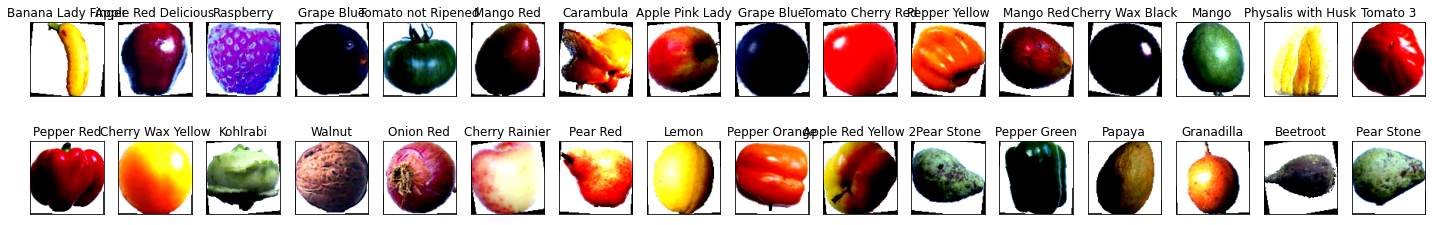

In [8]:
# Visualize a batch of data

def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    

# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display a batch of images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [10]:
#define the CNN architecture

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 500)
        self.fc2 = nn.Linear(500, 131)
        self.dropout = nn.Dropout(0.20)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #flatten the image
        x = x.view(-1, 64 * 12 * 12)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x
model = Network()

#added this line to load our half trained model
model.load_state_dict(torch.load('/content/drive/My Drive/datasets/fruits/custom_model.pt'))

if train_on_gpu:
    model.cuda()
model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=131, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.03)

In [14]:
# Function for the validation pass
def validation(model, validloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [ ]:
# Train the classifier

def train_classifier():

    epochs = 3
    valid_loss_min = np.Inf
    steps = 0
    print_every = 40

    model.to('cuda')

    for e in range(epochs):
    
        model.train()

        running_loss = 0

        for images, labels in iter(trainloader):
    
            steps += 1
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            optimizer.zero_grad()
    
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            if steps % print_every == 0:
            
                model.eval()
            
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validloader, criterion)
        
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))
                
                # save model if validation loss has decreased
                if validation_loss <= valid_loss_min:
                    print('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(
                    valid_loss_min,
                    validation_loss))
                    torch.save(model.state_dict(), '/content/drive/My Drive/datasets/fruits/custom_model.pt')
                    valid_loss_min = validation_loss
        
                running_loss = 0
                model.train()
                    
train_classifier()

Epoch: 1/3..  Training Loss: 4.863..  Validation Loss: 4.848..  Validation Accuracy: 0.019
Validation loss decreased (inf --> 2055.478).  Saving model ...
Epoch: 1/3..  Training Loss: 4.832..  Validation Loss: 4.772..  Validation Accuracy: 0.039
Validation loss decreased (2055.478 --> 2023.288).  Saving model ...
Epoch: 1/3..  Training Loss: 4.605..  Validation Loss: 4.311..  Validation Accuracy: 0.067
Validation loss decreased (2023.288 --> 1827.729).  Saving model ...
Epoch: 1/3..  Training Loss: 4.072..  Validation Loss: 3.852..  Validation Accuracy: 0.091
Validation loss decreased (1827.729 --> 1633.045).  Saving model ...
Epoch: 1/3..  Training Loss: 3.738..  Validation Loss: 3.429..  Validation Accuracy: 0.150
Validation loss decreased (1633.045 --> 1453.960).  Saving model ...
Epoch: 1/3..  Training Loss: 3.424..  Validation Loss: 2.883..  Validation Accuracy: 0.251
Validation loss decreased (1453.960 --> 1222.340).  Saving model ...
Epoch: 1/3..  Training Loss: 3.001..  Validat

In [17]:
# after retraining the model the validation accuracy was 95.9%

def test_accuracy(model, testloader):

    # Do validation on the test set
    model.eval()
    model.to('cuda')

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(testloader):
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(testloader)))    
        
        
test_accuracy(model, testloader)

Test Accuracy: 0.8731047511100769


In [18]:
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-96)/2
    bottom_margin = (pil_image.height-96)/2
    right_margin = left_margin + 96
    top_margin = bottom_margin + 96
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

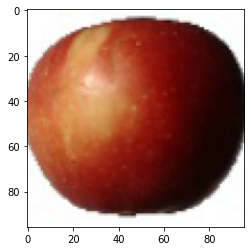

In [19]:

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('/content/drive/My Drive/datasets/fruits/test/Apple Braeburn/321_100.jpg')
imshow(image)

In [20]:
next(model.parameters()).is_cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print('Using device:', device)
model.to(device)
next(model.parameters()).is_cuda

True

In [28]:
# Implement the code to predict the class from an image file

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 

    top_indices = [round(x) for x in top_indices]
    
    #print(top_indices)
    #print(top_probabilities)
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    
    
    return top_probabilities, top_indices
    
probs, top_classes = predict('/content/drive/My Drive/datasets/fruits/test/Apricot/50_100.jpg', model)   
print(probs)
print(top_classes)

[673427200.0, 5065602.0, 3520564.75, 826944.6875, 228695.578125]
[13, 119, 80, 94, 96]


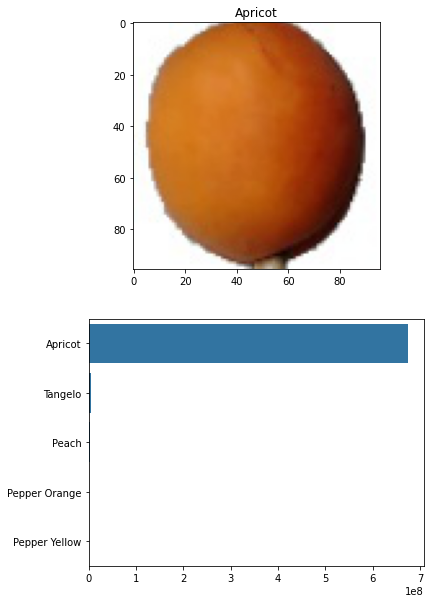

In [29]:
# Display an image along with the top 5 classes

# Plot flower input image
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

#image = process_image('flowers/test/1/image_06743.jpg')
image = process_image('/content/drive/My Drive/datasets/fruits/test/Apricot/50_100.jpg')

fruit_title = classes[top_classes[0]]

imshow(image, plot_1, title=fruit_title);

# Convert from the class integer encoding to actual flower names
fruite_names = [ classes[i] for i in top_classes]

# Plot the probabilities for the top 5 classes as a bar graph
plt.subplot(2,1,2)

sb.barplot(x=probs, y=fruite_names, color=sb.color_palette()[0]);

plt.show()

<h2>Thank You !</h2>